In [1]:
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
ad = sc.read_h5ad('../../data/talbot_xenium.h5ad')
ad = ad[ad.obs.tissue == 'tumor']
ad

View of AnnData object with n_obs × n_vars = 279424 × 5006
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'run', 'sample_folder', 'sample___', 'condition', 'tissue', 'genotype', 'timepoint', 'seg_method_short', 'n_genes_by_counts', 'sample_id'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'spatial'

In [10]:
ad.layers['raw'] = ad.X.copy()

In [3]:
sc.pp.calculate_qc_metrics(ad, percent_top=None, log1p=False, inplace=True)
sc.pp.filter_cells(ad,min_counts=30)
sc.pp.filter_cells(ad,min_genes=10)

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


In [40]:
sc.pp.normalize_total(ad, inplace=True,target_sum=100)
sc.pp.log1p(ad)

In [4]:
comparisons = {
    # 1. Pdl1_wt + C57 vs Pdl1_cre
    "Pdl1_wt+C57_vs_Pdl1_cre": {
        "case": ["output-XETG00045__0059973__Pdl1_cre__20250725__091031"],
        "control": [
            "output-XETG00045__0059973__Pdl1_wt__20250725__091031",
            "output-XETG00045__0059973__c57__20250725__091031"
        ]
    },

    # 2. Pdl1_wt vs Pdl1_cre
    "Pdl1_wt_vs_Pdl1_cre": {
        "case": ["output-XETG00045__0059973__Pdl1_cre__20250725__091031"],
        "control": ["output-XETG00045__0059973__Pdl1_wt__20250725__091031"]
    },

   # # 3. Overview of C57 wt
   # "C57_overview": {
    #    "case": ["output-XETG00045__0059973__c57__20250725__091031"],
     #   "control": []
    #},

    # 4. Oprl1_cre vs Oprl1_wt
    "Oprl1_cre_vs_Oprl1_wt": {
        "case": ["output-XETG00045__0059973__Oprl1_cre__20250725__091031"],
        "control": ["output-XETG00045__0059973__Oprl1_wt__20250725__091031"]
    }
}

In [6]:
# 1) map each file prefix to a condition label
file_to_condition = {
    "output-XETG00045__0059973__Pdl1_wt__20250725__091031":  "Pdl1_wt",
    "output-XETG00045__0059973__c57__20250725__091031":      "C57_wt",
    "output-XETG00045__0059973__Pdl1_cre__20250725__091031": "Pdl1_cre",
    "output-XETG00045__0059973__Oprl1_cre__20250725__091031":"Oprl1_cre",
    "output-XETG00045__0059973__Oprl1_wt__20250725__091031": "Oprl1_wt",
}

# add condition column (sample_id should carry those prefixes)
ad.obs["condition"] = ad.obs["sample___"].map(file_to_condition)

# 2) define comparisons by condition
comparisons = {
    # 1) (Pdl1_wt + C57_wt) vs Pdl1_cre
    "Pdl1_wt+C57_vs_Pdl1_cre": {
        "case":    ["Pdl1_cre"],
        "control": ["Pdl1_wt", "C57_wt"],
    },
    # 2) Pdl1_wt vs Pdl1_cre
    "Pdl1_wt_vs_Pdl1_cre": {
        "case":    ["Pdl1_cre"],
        "control": ["Pdl1_wt"],
    },
    # 4) Oprl1_cre vs Oprl1_wt
    "Oprl1_cre_vs_Oprl1_wt": {
        "case":    ["Oprl1_cre"],
        "control": ["Oprl1_wt"],
    },
}


In [7]:
ad.X.max()

408.0

In [8]:
import pandas as pd

COND_COL = "condition"
SAMPLE_COL = "sample_id"

# 1) Counts of UNIQUE samples per condition
sample_counts = ad.obs.groupby(COND_COL)[SAMPLE_COL].nunique().sort_values(ascending=False)
print("Unique samples per condition:\n", sample_counts)

# 2) List sample IDs per condition
cond_to_samples = (
    ad.obs.groupby(COND_COL)[SAMPLE_COL]
      .apply(lambda s: sorted(s.unique().tolist()))
      .to_dict()
)
print("\nSample IDs per condition:")
for cond, sids in cond_to_samples.items():
    print(f"- {cond} ({len(sids)}): {sids}")

# 3) Expand your condition-level comparisons into sample-level groups
comparisons = {
    "Pdl1_wt+C57_vs_Pdl1_cre": {"case": ["Pdl1_cre"], "control": ["Pdl1_wt", "C57_wt"]},
    "Pdl1_wt_vs_Pdl1_cre":     {"case": ["Pdl1_cre"], "control": ["Pdl1_wt"]},
    "Oprl1_cre_vs_Oprl1_wt":   {"case": ["Oprl1_cre"], "control": ["Oprl1_wt"]},
}

def expand_comparisons_to_samples(comparisons, cond_to_samples):
    """Return dict mapping comparison -> {'case_samples': [...], 'control_samples': [...]}."""
    out = {}
    for name, spec in comparisons.items():
        case_conditions = spec["case"]
        ctrl_conditions = spec["control"]
        # Gather sample IDs for each side, keeping order stable
        case_samples = sum([cond_to_samples.get(c, []) for c in case_conditions], [])
        ctrl_samples = sum([cond_to_samples.get(c, []) for c in ctrl_conditions], [])
        # Sanity checks
        overlap = set(case_samples) & set(ctrl_samples)
        if overlap:
            print(f"[WARN] Overlapping samples in {name}: {sorted(overlap)}")
        if len(case_samples) == 0 or len(ctrl_samples) == 0:
            print(f"[WARN] Empty group in {name}: case={len(case_samples)}, control={len(ctrl_samples)}")

        out[name] = {"case_samples": case_samples, "control_samples": ctrl_samples}
    return out

expanded = expand_comparisons_to_samples(comparisons, cond_to_samples)

print("\nExpanded comparisons (per-sample):")
for name, groups in expanded.items():
    print(f"\n{name}")
    print(f"  case    ({len(groups['case_samples'])}):    {groups['case_samples']}")
    print(f"  control ({len(groups['control_samples'])}): {groups['control_samples']}")

Unique samples per condition:
 condition
Pdl1_cre     4
C57_wt       3
Oprl1_cre    2
Pdl1_wt      2
Oprl1_wt     1
Name: sample_id, dtype: int64

Sample IDs per condition:
- Oprl1_cre (2): ['output-XETG00045__0059973__Oprl1_cre__20250725__091031_0', 'output-XETG00045__0059973__Oprl1_cre__20250725__091031_1']
- Oprl1_wt (1): ['output-XETG00045__0059973__Oprl1_wt__20250725__091031_0']
- Pdl1_cre (4): ['output-XETG00045__0059973__Pdl1_cre__20250725__091031_0', 'output-XETG00045__0059973__Pdl1_cre__20250725__091031_1', 'output-XETG00045__0059973__Pdl1_cre__20250725__091031_2', 'output-XETG00045__0059973__Pdl1_cre__20250725__091031_3']
- Pdl1_wt (2): ['output-XETG00045__0059973__Pdl1_wt__20250725__091031_0', 'output-XETG00045__0059973__Pdl1_wt__20250725__091031_1']
- C57_wt (3): ['output-XETG00045__0059973__c57__20250725__091031_0', 'output-XETG00045__0059973__c57__20250725__091031_1', 'output-XETG00045__0059973__c57__20250725__091031_2']

Expanded comparisons (per-sample):

Pdl1_wt+C57_vs

output-XETG00045__0059973__Pdl1_wt__20250725__091031


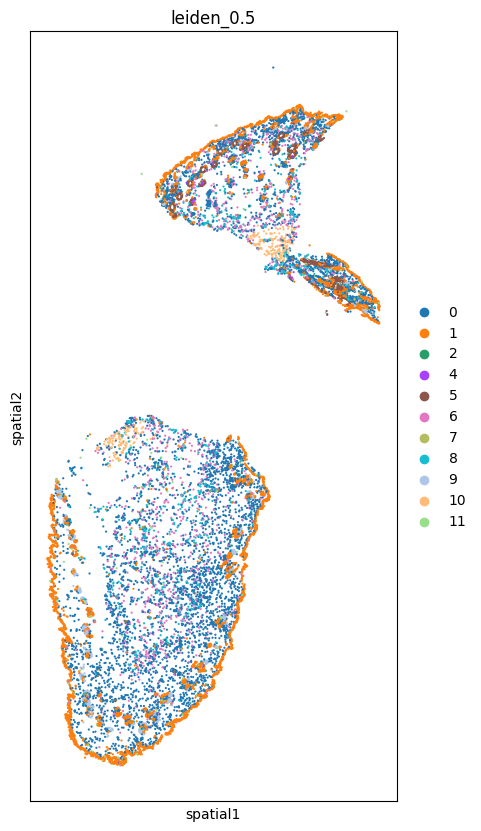

output-XETG00045__0059973__Oprl1_cre__20250725__091031


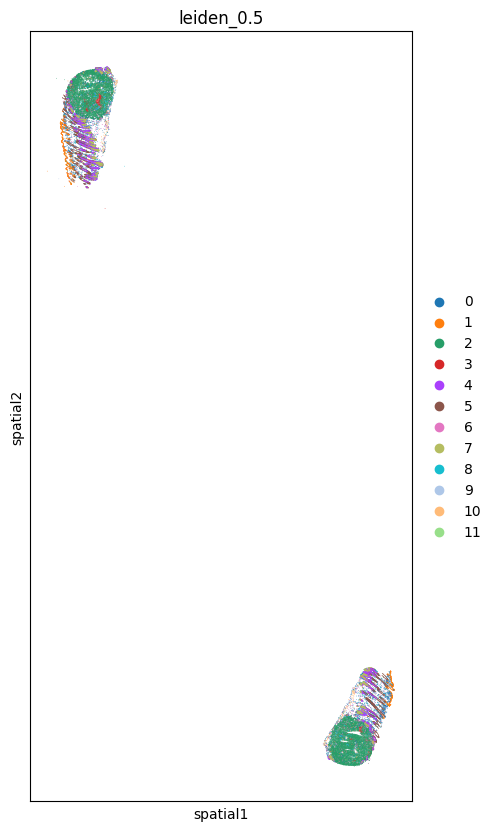

output-XETG00045__0059973__c57__20250725__091031


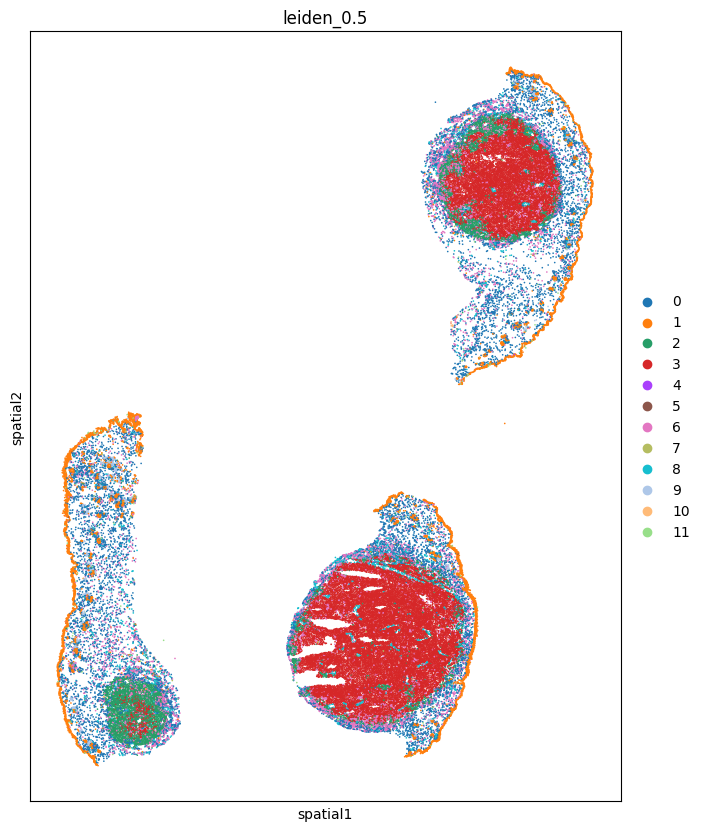

output-XETG00045__0059973__Oprl1_wt__20250725__091031


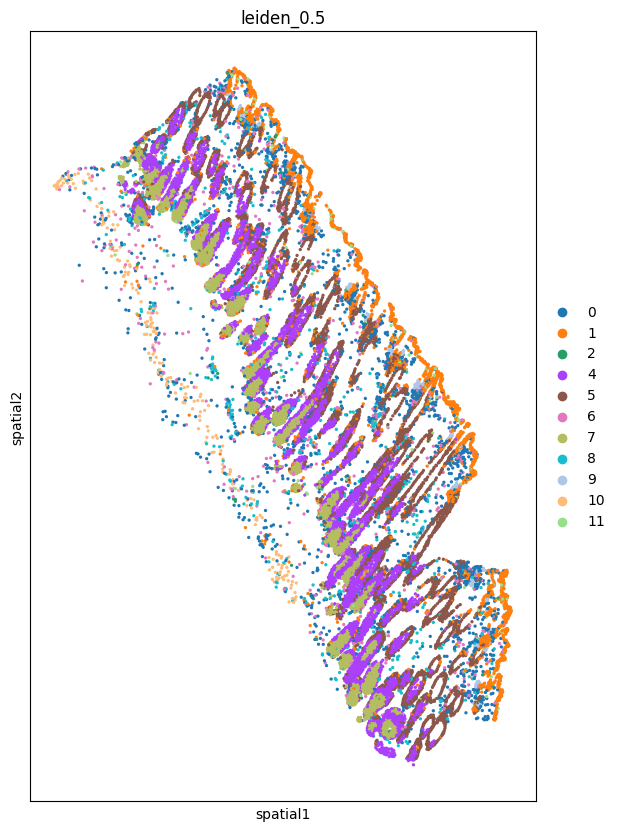

output-XETG00045__0059973__Pdl1_cre__20250725__091031


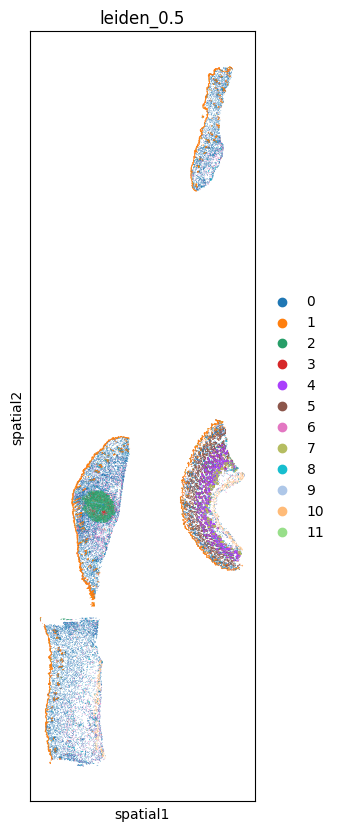

In [112]:
sample_id = []
for grid in ad.obs['sample___'].unique():
    print(grid)
    ad_int = ad[ad.obs['sample___'] == grid]
    with plt.rc_context({'figure.figsize': (20, 10)}):
        sc.pl.spatial(ad_int, spot_size=20, color = 'leiden_0.5')
   
    plt.show()


In [25]:
# =========================
# PSEUDOBULK + DE (from scratch)
# =========================
import numpy as np, pandas as pd
from scipy import sparse, stats
from statsmodels.stats.multitest import multipletests

# ---------- USER CONFIG ----------
COND_COL       = "condition"   # ad.obs column with condition labels
SAMPLE_COL     = "sample_id"   # ad.obs column with sample identifiers (replicates)
CELLTYPE_COL   = None          # e.g. "cell_type" to stratify; or None to pool all cells
MIN_TOTAL_COUNTS = 10          # prefilter genes: total pseudobulk counts across all samples >= this
PRIOR_COUNT      = 1.0         # logCPM prior
FDR_ALPHA        = 0.05

# Define comparisons by condition labels in ad.obs[COND_COL]
comparisons = {
    "Pdl1_wt+C57_vs_Pdl1_cre": {"case": ["Pdl1_cre"], "control": ["Pdl1_wt", "C57_wt"]},
    "Pdl1_wt_vs_Pdl1_cre":     {"case": ["Pdl1_cre"], "control": ["Pdl1_wt"]},
    "Oprl1_cre_vs_Oprl1_wt":   {"case": ["Oprl1_cre"], "control": ["Oprl1_wt"]},
}

# ---------- HELPERS ----------
def get_counts_and_genes(adata):
    """
    Returns (X, genes) where X is cells×genes counts and 'genes' matches X.
    Priority: layers['raw'] > layers['counts'] > ad.raw.X
    """
    if "raw" in adata.layers:
        X = adata.layers["raw"]
        genes = adata.var_names
    elif "counts" in adata.layers:
        X = adata.layers["counts"]
        genes = adata.var_names
    elif adata.raw is not None:
        X = adata.raw.X
        genes = adata.raw.var_names
    else:
        raise ValueError("No counts found. Expected ad.layers['raw'] or ['counts'] or ad.raw.X.")
    return X, pd.Index(genes)

def logcpm(counts, lib_sizes=None, prior_count=1.0, scale=1e6):
    """
    Log2-CPM with prior (edgeR-style).
    counts: genes×samples dense array
    """
    if lib_sizes is None:
        lib_sizes = counts.sum(axis=0)
    lib_sizes = np.asarray(lib_sizes, dtype=float).reshape(1, -1)
    cpm = (counts * scale) / np.maximum(lib_sizes, 1.0)
    return np.log2(cpm + prior_count)

def sanitize_pvals(p):
    """Replace NaN/Inf with 1, clip into (tiny,1]."""
    p = np.asarray(p, dtype=float)
    p[~np.isfinite(p)] = 1.0
    return np.clip(p, np.finfo(float).tiny, 1.0)

# ---------- CORE: PSEUDOBULK ----------
def pseudobulk_by_sample(adata, celltype_col=None):
    """
    Returns:
      pb_counts: DataFrame [genes × samples]
      sample_meta: DataFrame with columns [group_key, sample_id, condition, (celltype?)]
    """
    X, genes = get_counts_and_genes(adata)  # cells×genes
    X = X.tocsr() if sparse.issparse(X) else np.asarray(X)

    cols = [SAMPLE_COL, COND_COL] + ([celltype_col] if celltype_col else [])
    obs = adata.obs[cols].copy()

    group_key_cols = [SAMPLE_COL] + ([celltype_col] if celltype_col else [])
    key_df = obs[group_key_cols].astype(str)
    key_df["_grp"] = key_df.apply(lambda r: "||".join(r.values.tolist()), axis=1)
    groups, inv = np.unique(key_df["_grp"].values, return_inverse=True)

    G = len(groups)
    pb = np.zeros((X.shape[1], G), dtype=np.float64)  # genes×groups
    for g in range(G):
        idx = np.where(inv == g)[0]
        if len(idx) == 0:
            continue
        if sparse.issparse(X):
            pb[:, g] = X[idx, :].sum(axis=0).A1
        else:
            pb[:, g] = X[idx, :].sum(axis=0)

    # Build sample metadata (and map condition per sample_id)
    meta_parts = [g.split("||") for g in groups]
    meta_cols = [SAMPLE_COL] + ([celltype_col] if celltype_col else [])
    sample_meta = pd.DataFrame(meta_parts, columns=meta_cols)

    cond_map = (obs.groupby(SAMPLE_COL)[COND_COL]
                  .agg(lambda s: s.unique()[0] if s.nunique()==1 else s.mode().iloc[0])
                  .to_dict())
    sample_meta[COND_COL] = sample_meta[SAMPLE_COL].map(cond_map)

    colnames = [
        f"{r[SAMPLE_COL]}" + (f"|{r[celltype_col]}" if celltype_col else "")
        for _, r in sample_meta.iterrows()
    ]
    pb_counts = pd.DataFrame(pb, index=genes, columns=colnames)
    sample_meta["group_key"] = colnames

    # Drop any all-zero columns (rare but safe)
    keep_cols = pb_counts.sum(axis=0) > 0
    if (~keep_cols).any():
        pb_counts = pb_counts.loc[:, keep_cols.values]
        sample_meta = sample_meta.loc[keep_cols.values].reset_index(drop=True)

    return pb_counts, sample_meta

# ---------- CORE: DE ----------
def run_de_welch_logcpm(logcpm_mat, sample_meta, case_conditions, ctrl_conditions):
    """
    Welch's t-test on logCPM for case vs control.
    Returns a tidy DE DataFrame indexed by gene.
    """
    sel_case = sample_meta[sample_meta[COND_COL].isin(case_conditions)]["group_key"].tolist()
    sel_ctrl = sample_meta[sample_meta[COND_COL].isin(ctrl_conditions)]["group_key"].tolist()
    n_case, n_ctrl = len(sel_case), len(sel_ctrl)
    if n_case < 2 or n_ctrl < 2:
        print(f"[WARN] Low replicate counts: case={n_case}, control={n_ctrl}. Stats will be weak.")

    Xc = logcpm_mat[sel_case].to_numpy()  # genes×n_case
    Xn = logcpm_mat[sel_ctrl].to_numpy()  # genes×n_ctrl

    mean_case = Xc.mean(axis=1)
    mean_ctrl = Xn.mean(axis=1)
    log2fc = mean_case - mean_ctrl

    t_stat, pvals = stats.ttest_ind(Xc, Xn, equal_var=False, axis=1, nan_policy="omit")
    pvals = sanitize_pvals(pvals)
    padj = multipletests(pvals, method="fdr_bh")[1]

    de = pd.DataFrame({
        "gene": logcpm_mat.index.values,
        "log2fc": log2fc,
        "pval": pvals,
        "padj": padj,
        "mean_logCPM_case": mean_case,
        "mean_logCPM_ctrl": mean_ctrl,
        "n_case_samples": n_case,
        "n_ctrl_samples": n_ctrl,
        "mode": "pseudobulk_mean",
    }).set_index("gene").sort_values(["padj","pval","log2fc"], ascending=[True,True,False])

    return de

# ---------- DRIVER ----------
def run_pseudobulk_de(adata, comparisons, celltype_col=None,
                      min_total_counts=MIN_TOTAL_COUNTS, prior_count=PRIOR_COUNT, alpha=FDR_ALPHA):
    # 1) pseudobulk
    pb_counts, sample_meta = pseudobulk_by_sample(adata, celltype_col=celltype_col)

    # 2) crude prefilter BEFORE logCPM
    if min_total_counts is not None and min_total_counts > 0:
        keep = (pb_counts.sum(axis=1) >= min_total_counts)
        pb_counts = pb_counts.loc[keep]

    # 3) logCPM
    lib_sizes = pb_counts.sum(axis=0).values
    logcpm_mat = pd.DataFrame(
        logcpm(pb_counts.values, lib_sizes=lib_sizes, prior_count=prior_count, scale=1e6),
        index=pb_counts.index, columns=pb_counts.columns
    )

    # 4) DE per comparison
    results = {}
    for name, spec in comparisons.items():
        de = run_de_welch_logcpm(logcpm_mat, sample_meta, spec["case"], spec["control"])
        results[name] = de
        # quick summary
        sig = (de["padj"] <= alpha).sum()
        print(f"\n=== {name} ===")
        print(f"tested genes: {de.shape[0]} | significant @ FDR≤{alpha}: {sig}")
        print(de.head(10)[["log2fc","pval","padj","n_case_samples","n_ctrl_samples"]])

    return results, pb_counts, sample_meta, logcpm_mat

# ----------------- RUN -----------------
results, pb_counts, sample_meta, logcpm_mat = run_pseudobulk_de(
    ad, comparisons, celltype_col=CELLTYPE_COL,
    min_total_counts=MIN_TOTAL_COUNTS, prior_count=PRIOR_COUNT, alpha=FDR_ALPHA
)

# Example: access and save one result
# name = "Pdl1_wt+C57_vs_Pdl1_cre"
# results[name].to_csv(f"{name}__pseudobulk_DE.csv")


=== Pdl1_wt+C57_vs_Pdl1_cre ===
tested genes: 4957 | significant @ FDR≤0.05: 0
           log2fc      pval      padj  n_case_samples  n_ctrl_samples
gene                                                                 
Agtrap  -0.713812  0.001031  0.732923               4               5
Grk2    -0.447716  0.001159  0.732923               4               5
Pou6f1  -1.271629  0.001293  0.732923               4               5
Stimate -0.843380  0.001762  0.732923               4               5
Limd1   -0.480044  0.001833  0.732923               4               5
Prf1    -1.594442  0.002972  0.732923               4               5
Cyren    0.891063  0.003024  0.732923               4               5
Mpl      0.885442  0.003275  0.732923               4               5
Brpf3   -0.980551  0.003699  0.732923               4               5
Fbxl4   -0.287267  0.003709  0.732923               4               5

=== Pdl1_wt_vs_Pdl1_cre ===
tested genes: 4957 | significant @ FDR≤0.05: 0
    

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_12859/3778190077.py:132: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, pvals = stats.ttest_ind(Xc, Xn, equal_var=False, axis=1, nan_policy="omit")
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [28]:
results['Pdl1_wt_vs_Pdl1_cre'].sort_values('log2fc')

,log2fc,pval,padj,mean_logCPM_case,mean_logCPM_ctrl,n_case_samples,n_ctrl_samples,mode
gene,,,,,,,,
Myh4,-3.584009,0.206299,0.750224,7.501905,11.085914,4,2,pseudobulk_mean
Cyp2g1,-3.162470,0.287440,0.761293,6.604175,9.766645,4,2,pseudobulk_mean
Scn4a,-3.100795,0.110150,0.750224,3.640453,6.741248,4,2,pseudobulk_mean
Ttn,-2.911917,0.178950,0.750224,6.489458,9.401375,4,2,pseudobulk_mean
Casq1,-2.831436,0.233513,0.750224,5.425558,8.256993,4,2,pseudobulk_mean
...,...,...,...,...,...,...,...,...
Trpm1,2.812221,0.084736,0.750224,6.508391,3.696170,4,2,pseudobulk_mean
Cpne4,2.957002,0.280176,0.757678,4.611392,1.654390,4,2,pseudobulk_mean
Sox11,2.961354,0.148685,0.750224,6.271440,3.310086,4,2,pseudobulk_mean


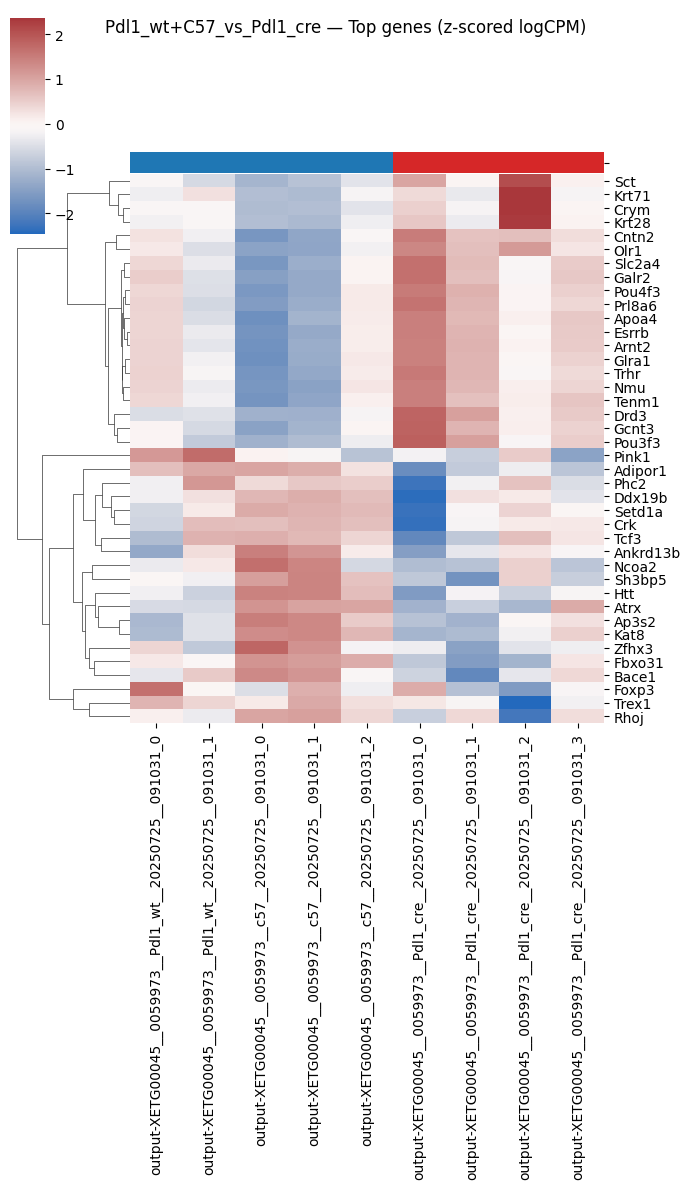

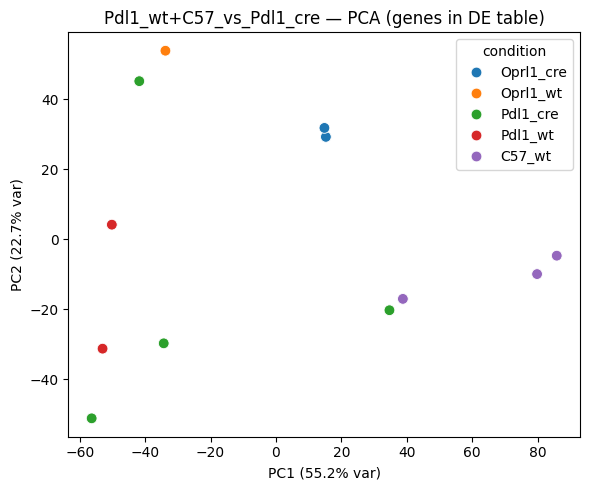

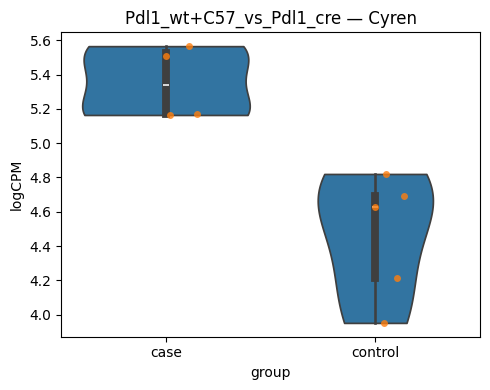

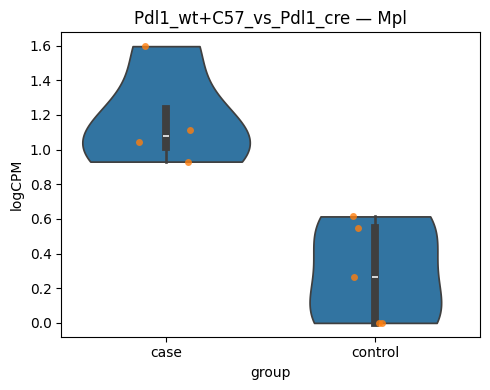

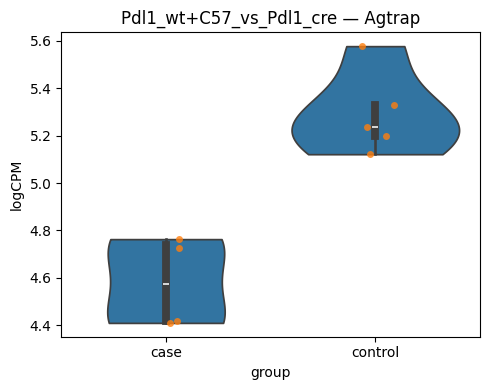

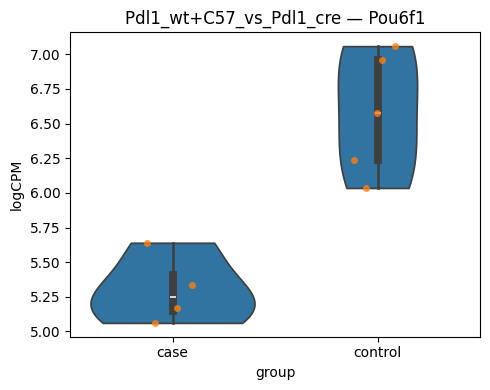

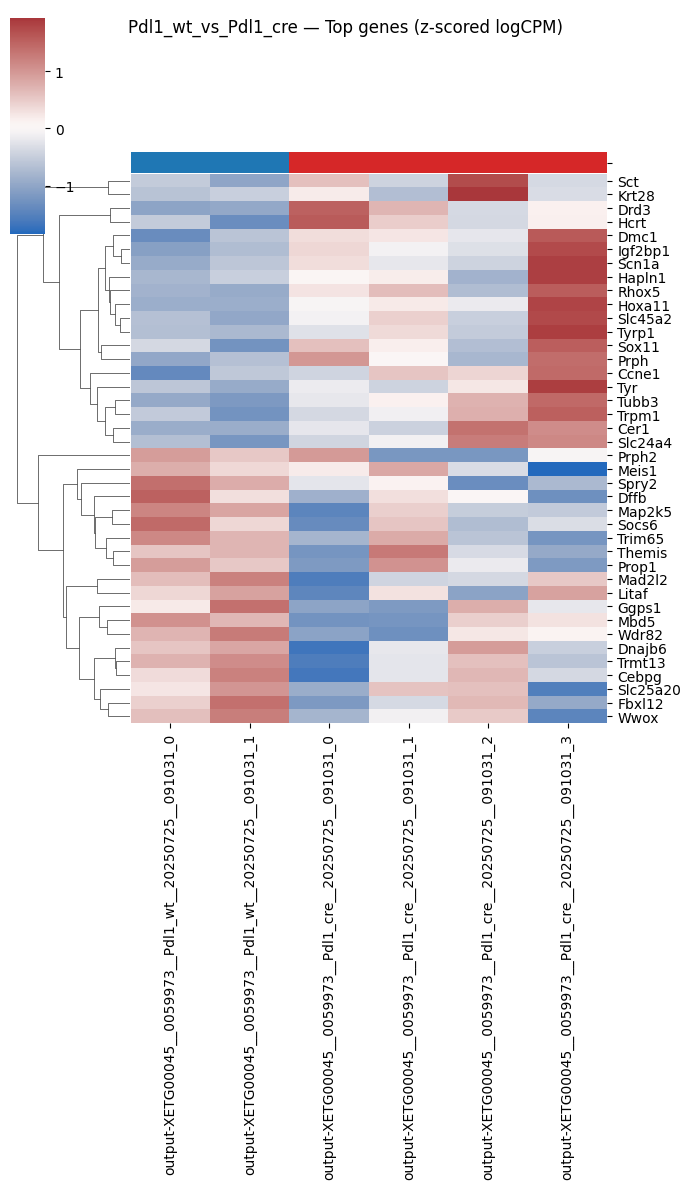

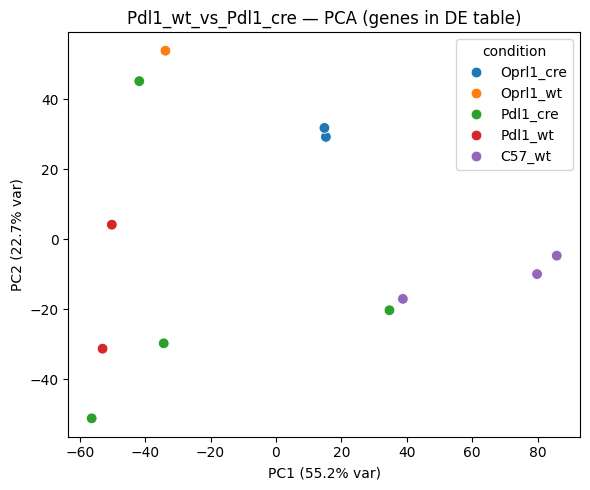

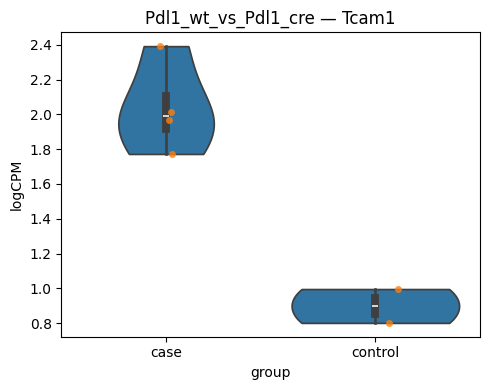

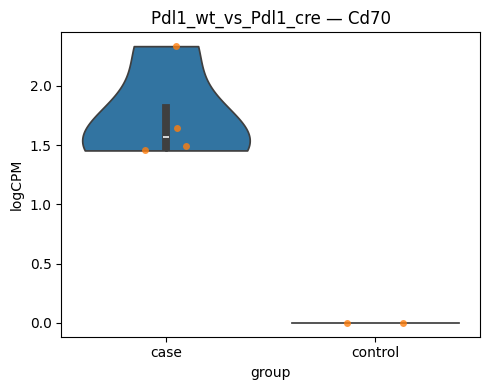

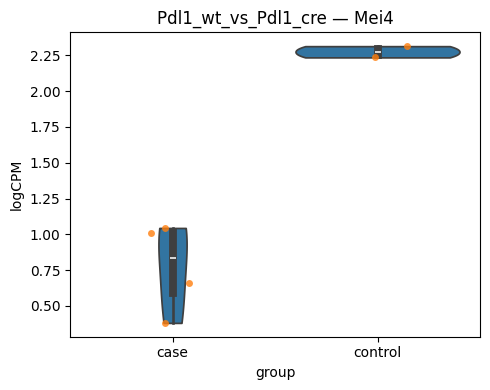

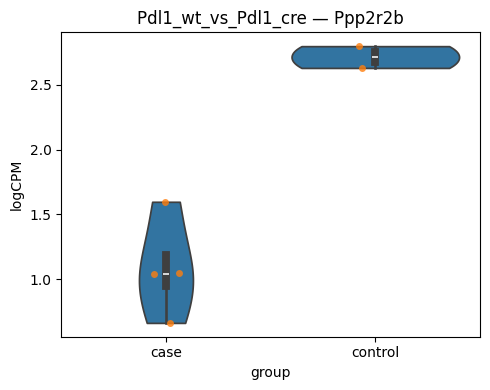

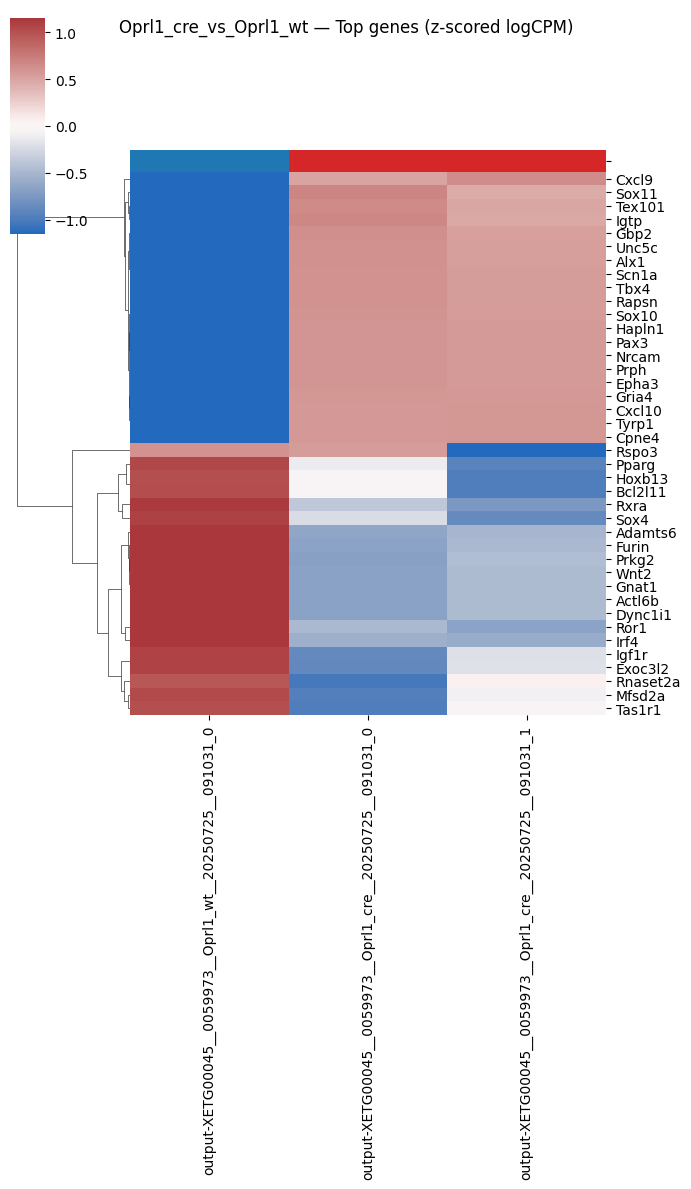

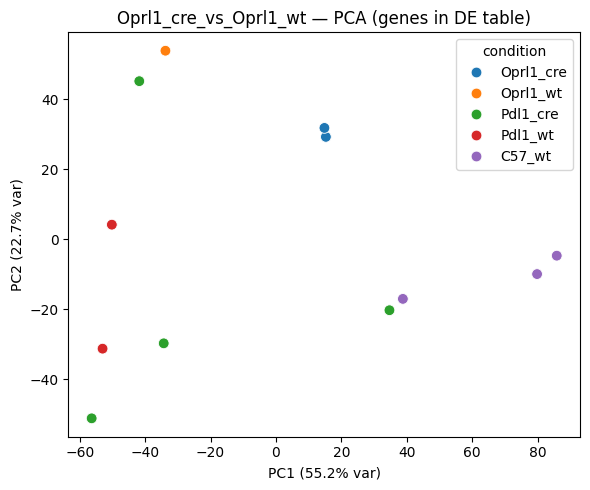

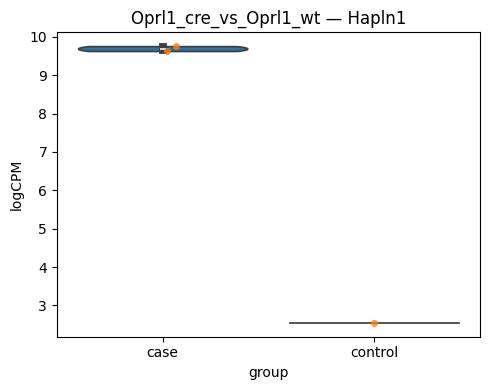

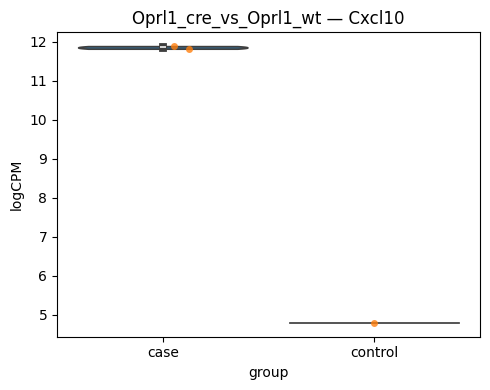

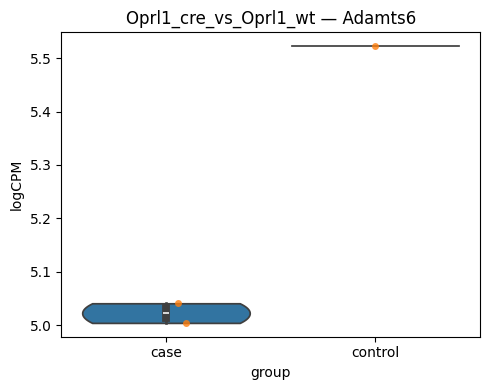

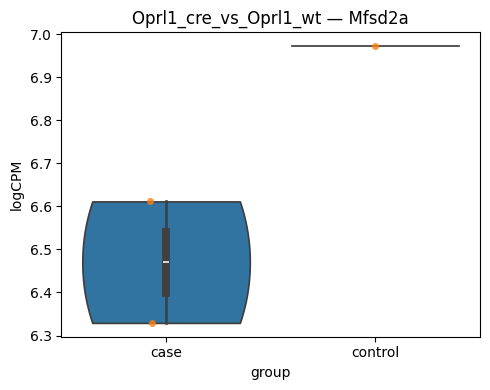

In [39]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# ---------- CONFIG ----------
FDR_THR  = 1
LFC_THR  = 0.5
TOP_N    = 20
FIGSIZE  = (6,5)

def _sig_mask(df, fdr_thr=FDR_THR, lfc_thr=LFC_THR):
    return (df["padj"] <= fdr_thr) & (df["log2fc"].abs() >= lfc_thr)

# ---------- VOLCANO ----------
def plot_volcano(de, title="", fdr_thr=FDR_THR, lfc_thr=LFC_THR, top_n=TOP_N, annotate=True):
    df = de.copy()
    # Handle filtered genes (padj NaN) by setting for plotting only
    df["padj_plot"] = df["padj"].fillna(1.0)
    df["neglog10_padj"] = -np.log10(df["padj_plot"].clip(lower=1e-300))

    sig = (df["padj_plot"] <= fdr_thr) & (df["log2fc"].abs() >= lfc_thr)

    plt.figure(figsize=FIGSIZE)
    plt.scatter(df.loc[~sig, "log2fc"], df.loc[~sig, "neglog10_padj"], s=8, alpha=0.4)
    plt.scatter(df.loc[sig,  "log2fc"], df.loc[sig,  "neglog10_padj"], s=10, alpha=0.85)

    plt.axvline(+lfc_thr, ls="--", lw=1, color="grey")
    plt.axvline(-lfc_thr, ls="--", lw=1, color="grey")
    plt.axhline(-np.log10(fdr_thr), ls="--", lw=1, color="grey")

    plt.xlabel("log2FC (case vs control)")
    plt.ylabel("-log10(FDR)")
    plt.title(title or "Volcano")

    if annotate:
        # label significant if any; else label top_n by raw p
        if sig.any():
            lab = df[sig].nsmallest(top_n, "padj_plot")
        else:
            lab = df.nsmallest(top_n, "pval")
        for g, r in lab.iterrows():
            plt.text(r["log2fc"], r["neglog10_padj"], g, fontsize=7, ha="left", va="bottom", alpha=0.8)

    plt.tight_layout()
    plt.show()

# ---------- MA ----------
def plot_ma(de, title="MA"):
    df = de.copy()
    df["A"] = (df["mean_logCPM_case"] + df["mean_logCPM_ctrl"]) / 2.0
    sig = _sig_mask(df)

    plt.figure(figsize=FIGSIZE)
    plt.scatter(df.loc[~sig,"A"], df.loc[~sig,"log2fc"], s=8, alpha=0.4)
    plt.scatter(df.loc[sig, "A"], df.loc[sig, "log2fc"], s=10, alpha=0.85)
    plt.axhline(0, ls="--", lw=1, color="grey")
    plt.xlabel("Mean logCPM")
    plt.ylabel("log2FC (case vs control)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ---------- HEATMAP (top DE genes) ----------
def plot_heatmap_top(de, logcpm_mat, sample_meta, case_conditions, ctrl_conditions,
                     top_n=TOP_N, title="Top DE genes (z-scored logCPM)"):
    df = de.copy()
    tested = df[~df["padj"].isna()]  # only genes actually tested

    if tested.empty:
        print("[info] No tested genes to display.")
        return

    # Prefer significant genes; else fallback to best by raw p
    candidates = tested[_sig_mask(tested)]
    if candidates.empty:
        candidates = tested.nsmallest(2*top_n, "pval")  # symmetric-ish size
    else:
        # take top_n up + top_n down by FDR then |LFC|
        up = candidates[candidates["log2fc"]>0].sort_values(["padj","log2fc"], ascending=[True,False]).head(top_n)
        dn = candidates[candidates["log2fc"]<0].sort_values(["padj","log2fc"], ascending=[True,False]).head(top_n)
        candidates = pd.concat([up, dn])

    genes = candidates.index.tolist()

    case_cols = sample_meta[sample_meta["condition"].isin(case_conditions)]["group_key"].tolist()
    ctrl_cols = sample_meta[sample_meta["condition"].isin(ctrl_conditions)]["group_key"].tolist()
    cols = ctrl_cols + case_cols  # controls first, then cases

    M = logcpm_mat.loc[genes, cols]
    Z = (M - M.mean(axis=1).values[:,None]) / (M.std(axis=1).values[:,None] + 1e-9)

    # condition color bar
    col_colors = pd.Series(index=cols, dtype="object")
    for c in ctrl_cols: col_colors[c] = "tab:blue"
    for c in case_cols: col_colors[c] = "tab:red"

    g = sns.clustermap(Z, row_cluster=True, col_cluster=False, cmap="vlag",
                       col_colors=col_colors[cols], figsize=(7,12))
    g.fig.suptitle(title)
    plt.show()

# ---------- PCA (samples) ----------
def plot_sample_pca(logcpm_mat, sample_meta, title="PCA (samples)"):
    X = logcpm_mat.T  # samples × genes
    Xc = X - X.mean(axis=0)
    pca = PCA(n_components=2, random_state=0).fit(Xc)
    PCs = pca.transform(Xc)
    dfp = pd.DataFrame(PCs, index=X.index, columns=["PC1","PC2"]).reset_index().rename(columns={"index":"group_key"})
    dfp = dfp.merge(sample_meta[["group_key","condition"]], on="group_key", how="left")

    plt.figure(figsize=FIGSIZE)
    sns.scatterplot(data=dfp, x="PC1", y="PC2", hue="condition", s=60)
    ve = pca.explained_variance_ratio_ * 100
    plt.xlabel(f"PC1 ({ve[0]:.1f}% var)")
    plt.ylabel(f"PC2 ({ve[1]:.1f}% var)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ---------- Per-gene violin ----------
def plot_gene_violin(gene, logcpm_mat, sample_meta, case_conditions, ctrl_conditions, title=None):
    case_cols = sample_meta[sample_meta["condition"].isin(case_conditions)]["group_key"].tolist()
    ctrl_cols = sample_meta[sample_meta["condition"].isin(ctrl_conditions)]["group_key"].tolist()

    data = []
    for c in case_cols:
        data.append({"group":"case", "value": logcpm_mat.at[gene, c], "sample": c})
    for c in ctrl_cols:
        data.append({"group":"control", "value": logcpm_mat.at[gene, c], "sample": c})
    df = pd.DataFrame(data)

    plt.figure(figsize=(5,4))
    sns.violinplot(data=df, x="group", y="value", inner="box", cut=0)
    sns.stripplot(data=df, x="group", y="value", alpha=0.8, jitter=0.15)
    plt.ylabel("logCPM")
    plt.title(title or gene)
    plt.tight_layout()
    plt.show()

# ---------- Driver to render a full panel for ONE comparison ----------
def visualize_comparison(name, results, sample_meta, logcpm_mat, comparisons,
                         fdr_thr=FDR_THR, lfc_thr=LFC_THR, top_n=TOP_N, show_example_violins=True):
    de = results[name]
    case_conds = comparisons[name]["case"]
    ctrl_conds = comparisons[name]["control"]

    # Volcano / MA
    #plot_volcano(de, title=f"{name} — Volcano", fdr_thr=fdr_thr, lfc_thr=lfc_thr, top_n=top_n)
    #plot_ma(de, title=f"{name} — MA")

    # Heatmap (top genes)
    plot_heatmap_top(de, logcpm_mat, sample_meta, case_conds, ctrl_conds,
                     top_n=top_n, title=f"{name} — Top genes (z-scored logCPM)")

    # PCA
    plot_sample_pca(logcpm_mat.loc[de.index], sample_meta, title=f"{name} — PCA (genes in DE table)")

    # Example violins
    if show_example_violins:
        tested = de[~de["padj"].isna()]
        if tested.empty:
            return
        sig = tested[_sig_mask(tested, fdr_thr, lfc_thr)]
        if sig.empty:
            genes_to_show = tested.nsmallest(3, "pval").index.tolist()
        else:
            genes_to_show = pd.concat([
                sig[sig["log2fc"]>0].head(2),
                sig[sig["log2fc"]<0].head(2)
            ]).index.unique().tolist()
        for g in genes_to_show:
            plot_gene_violin(g, logcpm_mat, sample_meta, case_conds, ctrl_conds, title=f"{name} — {g}")

# ---------- Usage ----------
# Single comparison:
# visualize_comparison("Pdl1_wt+C57_vs_Pdl1_cre", results, sample_meta, logcpm_mat, comparisons)

# Or loop all:
for comp_name in comparisons:
     visualize_comparison(comp_name, results, sample_meta, logcpm_mat, comparisons)

In [42]:
ad.obs

,x_centroid,y_centroid,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,...,sample___,condition,tissue,genotype,timepoint,seg_method_short,n_genes_by_counts,sample_id,n_counts,n_genes
output-XETG00045__0059973__Pdl1_wt__20250725__091031_aaachibf-1,2893.360596,691.736328,256,0,0,0,0,0,256.0,52.290939,...,output-XETG00045__0059973__Pdl1_wt__20250725__...,Pdl1_wt,tumor,Pdl1_wt,NaN,Boundary (ATP1A1+CD45+E-Cad),211,output-XETG00045__0059973__Pdl1_wt__20250725__...,256.0,211
output-XETG00045__0059973__Pdl1_wt__20250725__091031_aaadbpmc-1,2899.480713,684.565002,159,0,0,0,0,0,159.0,28.042032,...,output-XETG00045__0059973__Pdl1_wt__20250725__...,Pdl1_wt,tumor,Pdl1_wt,NaN,Boundary (ATP1A1+CD45+E-Cad),128,output-XETG00045__0059973__Pdl1_wt__20250725__...,159.0,128
output-XETG00045__0059973__Pdl1_wt__20250725__091031_aaagejpm-1,2897.230469,687.607605,122,0,0,1,0,0,122.0,28.087189,...,output-XETG00045__0059973__Pdl1_wt__20250725__...,Pdl1_wt,tumor,Pdl1_wt,NaN,Boundary (ATP1A1+CD45+E-Cad),105,output-XETG00045__0059973__Pdl1_wt__20250725__...,122.0,105
output-XETG00045__0059973__Pdl1_wt__20250725__091031_aaagiphc-1,2894.634766,678.341003,400,0,0,0,1,0,400.0,74.823909,...,output-XETG00045__0059973__Pdl1_wt__20250725__...,Pdl1_wt,tumor,Pdl1_wt,NaN,Boundary (ATP1A1+CD45+E-Cad),312,output-XETG00045__0059973__Pdl1_wt__20250725__...,400.0,312
output-XETG00045__0059973__Pdl1_wt__20250725__091031_aaahpgfk-1,2913.239258,671.052002,208,0,0,0,0,0,208.0,56.851721,...,output-XETG00045__0059973__Pdl1_wt__20250725__...,Pdl1_wt,tumor,Pdl1_wt,NaN,Boundary (ATP1A1+CD45+E-Cad),169,output-XETG00045__0059973__Pdl1_wt__20250725__...,208.0,169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
output-XETG00045__0059973__Pdl1_cre__20250725__091031_oikfjlfk-1,5641.817871,15589.317383,49,0,0,0,0,0,49.0,200.855007,...,output-XETG00045__0059973__Pdl1_cre__20250725_...,Pdl1_cre,tumor,Pdl1_cre,NaN,Nucleus+5µm,45,output-XETG00045__0059973__Pdl1_cre__20250725_...,49.0,45
output-XETG00045__0059973__Pdl1_cre__20250725__091031_oilbhfce-1,5555.447266,15552.618164,35,0,0,0,0,0,35.0,40.369689,...,output-XETG00045__0059973__Pdl1_cre__20250725_...,Pdl1_cre,tumor,Pdl1_cre,NaN,Nucleus+5µm,32,output-XETG00045__0059973__Pdl1_cre__20250725_...,35.0,32
output-XETG00045__0059973__Pdl1_cre__20250725__091031_oilfjaec-1,5831.701660,14950.695312,108,0,0,0,0,0,108.0,164.142975,...,output-XETG00045__0059973__Pdl1_cre__20250725_...,Pdl1_cre,tumor,Pdl1_cre,NaN,Nucleus+5µm,72,output-XETG00045__0059973__Pdl1_cre__20250725_...,108.0,72
output-XETG00045__0059973__Pdl1_cre__20250725__091031_oilfkjkg-1,5718.615234,14955.312500,100,0,0,0,0,0,100.0,112.529379,...,output-XETG00045__0059973__Pdl1_cre__20250725_...,Pdl1_cre,tumor,Pdl1_cre,NaN,Nucleus+5µm,82,output-XETG00045__0059973__Pdl1_cre__20250725_...,100.0,82


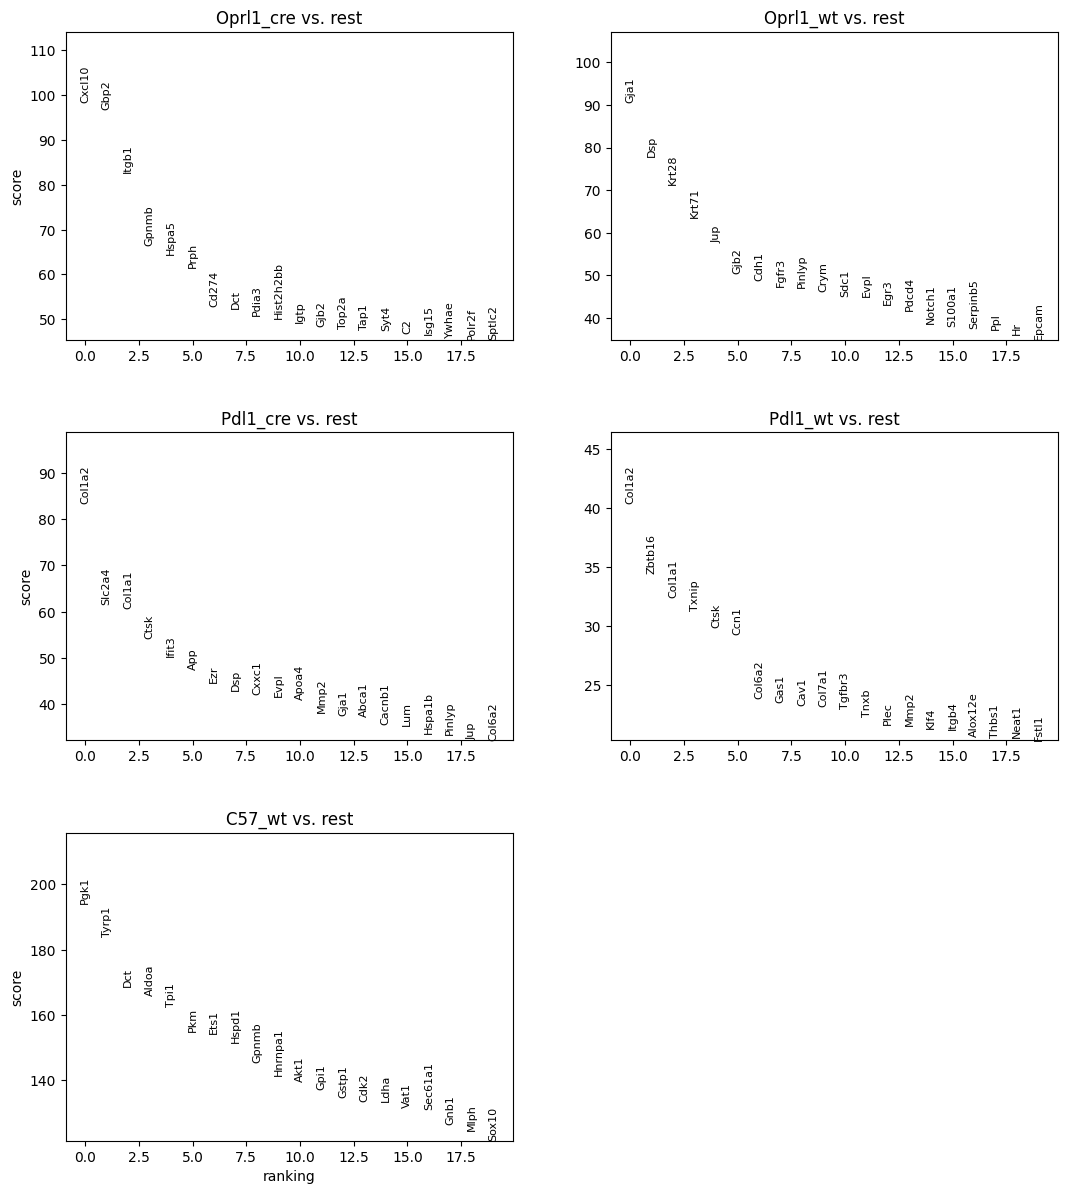

In [47]:
# Run DE between groups in adata.obs["condition"]
sc.tl.rank_genes_groups(
    ad,
    groupby="condition",          # column in .obs
    method="t-test",              # or "wilcoxon" / "logreg"
    reference="control_group"     # pick which group to compare against
)

# Inspect results
sc.pl.rank_genes_groups(ad, n_genes=20, sharey=False, ncols= 2)


=== Pdl1_wt+C57_vs_Pdl1_cre ===
     gene  logfoldchange           pval       pval_adj
0     Dsp       1.415074   0.000000e+00   0.000000e+00
1    Gja1       2.175006   0.000000e+00   0.000000e+00
2   Krt28       5.222793   0.000000e+00   0.000000e+00
3   Krt71       4.761485   0.000000e+00   0.000000e+00
4     Jup       1.230507   0.000000e+00   0.000000e+00
5    Evpl       1.797094   0.000000e+00   0.000000e+00
6  Pinlyp       2.875247   0.000000e+00   0.000000e+00
7  Slc2a4       2.249198   0.000000e+00   0.000000e+00
8    Crym       6.052129  1.588063e-264  7.187924e-264
9   Fgfr3       1.574138  3.602078e-180  1.346677e-179


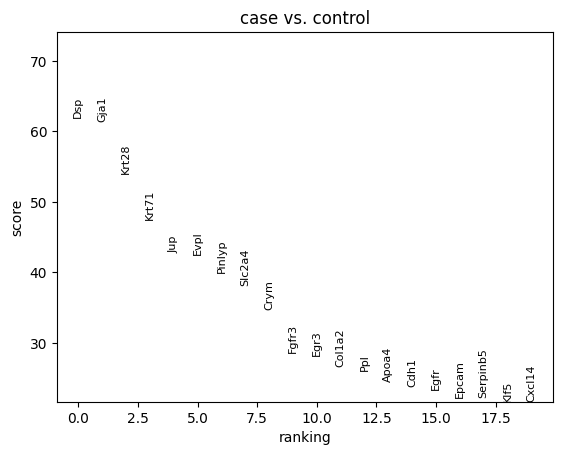


=== Pdl1_wt_vs_Pdl1_cre ===
        gene  logfoldchange           pval       pval_adj
0      Krt28       4.655633  3.486962e-242  1.745573e-238
1      Krt71       3.862919  3.087576e-192  7.728202e-189
2       Gja1       1.136557  1.010234e-156  1.685744e-153
3       Cct3       1.037145  1.106472e-146  1.384749e-143
4      Hspa5       0.704884  7.137811e-124  7.146376e-121
5  Hist2h2bb       1.505523  7.780190e-122  6.491272e-119
6      Gpnmb       2.135886  2.064009e-113  1.476062e-110
7      Ywhae       0.677662  7.478309e-112  4.679552e-109
8     Slc2a4       1.580654   2.029968e-99   1.129113e-96
9       Sdhb       0.930279   8.441112e-98   4.225621e-95


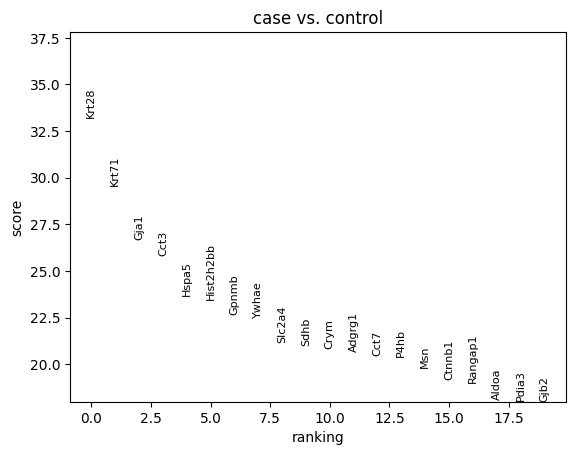


=== Oprl1_cre_vs_Oprl1_wt ===
        gene  logfoldchange  pval  pval_adj
0      Gpnmb       2.823780   0.0       0.0
1        Dct       4.383765   0.0       0.0
2      Tyrp1       4.463410   0.0       0.0
3     Cxcl10       6.613869   0.0       0.0
4      Itgb1       1.577184   0.0       0.0
5       Gbp2       4.329773   0.0       0.0
6        Msn       1.022324   0.0       0.0
7      Hspd1       1.390419   0.0       0.0
8      Hspa5       0.947546   0.0       0.0
9  Hist2h2bb       0.952040   0.0       0.0


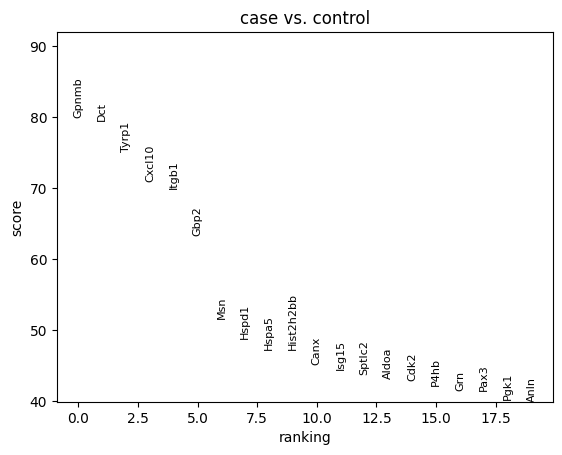

In [48]:
import scanpy as sc
import pandas as pd

# Your dictionary
comparisons = {
    "Pdl1_wt+C57_vs_Pdl1_cre": {"case": ["Pdl1_cre"], "control": ["Pdl1_wt", "C57_wt"]},
    "Pdl1_wt_vs_Pdl1_cre":     {"case": ["Pdl1_cre"], "control": ["Pdl1_wt"]},
    "Oprl1_cre_vs_Oprl1_wt":   {"case": ["Oprl1_cre"], "control": ["Oprl1_wt"]},
}

results_scanpy = {}

for name, spec in comparisons.items():
    case_conditions = spec["case"]
    ctrl_conditions = spec["control"]

    # Make a temporary grouping column in .obs
    ad.obs["group_DE"] = "rest"
    ad.obs.loc[ad.obs["condition"].isin(case_conditions), "group_DE"] = "case"
    ad.obs.loc[ad.obs["condition"].isin(ctrl_conditions), "group_DE"] = "control"

    # Subset only case + control cells
    ad_sub = ad[ad.obs["group_DE"].isin(["case","control"])].copy()

    # Run DE
    sc.tl.rank_genes_groups(
        ad_sub,
        groupby="group_DE",
        method="wilcoxon",      # or "t-test"
        reference="control"     # always compare case vs control
    )

    # Save results to a tidy DataFrame
    de_res = ad_sub.uns["rank_genes_groups"]
    case_group = "case"

    df = pd.DataFrame({
        "gene": de_res["names"][case_group],
        "logfoldchange": de_res["logfoldchanges"][case_group],
        "pval": de_res["pvals"][case_group],
        "pval_adj": de_res["pvals_adj"][case_group],
    })
    results_scanpy[name] = df

    print(f"\n=== {name} ===")
    print(df.head(10))

    # Quick plot for top genes
    sc.pl.rank_genes_groups(ad_sub, n_genes=20, sharey=False, ncols=2, title=name)

In [54]:
def nice_volcano(
    df,
    title="",
    fdr_thr=0.05,
    lfc_thr=0.5,
    top_n_each=10,
    max_nonsig_points=8000,
    y_cap_quantile=0.99,
    xlim=None,               # <-- NEW: pass a tuple like (-3, 3)
    savepath=None,
):
    df = df.copy()

    # choose p-values (prefer adj)
    if "pval_adj" in df.columns and df["pval_adj"].notna().any():
        p = df["pval_adj"].astype(float)
        y_label = "-log10(FDR)"
    elif "pval" in df.columns:
        p = df["pval"].astype(float)
        y_label = "-log10(p)"
    else:
        raise ValueError("Need 'pval_adj' or 'pval' in df.")

    tiny = np.nextafter(0, 1)
    p = p.replace([np.inf, -np.inf], np.nan).fillna(1.0).clip(tiny, 1.0)
    df["logFC"] = df["logfoldchange"].astype(float)
    df["neglog10p"] = -np.log10(p.values)

    sig = (p.values <= fdr_thr) & (np.abs(df["logFC"].values) >= lfc_thr)

    y_cap = np.quantile(df["neglog10p"], y_cap_quantile)
    y_cap = max(y_cap, -np.log10(fdr_thr) + 1)
    df["yplot"] = np.minimum(df["neglog10p"], y_cap)

    # downsample non-significant
    nonsig_idx = np.where(~sig)[0]
    if len(nonsig_idx) > max_nonsig_points:
        keep_ns = rng.choice(nonsig_idx, size=max_nonsig_points, replace=False)
        show_idx = np.concatenate([keep_ns, np.where(sig)[0]])
    else:
        show_idx = np.arange(len(df))

    plt.figure(figsize=(6.5, 5.2))
    shown = df.iloc[show_idx]

    plt.scatter(shown.loc[~shown.index.isin(df.index[sig]), "logFC"],
                shown.loc[~shown.index.isin(df.index[sig]), "yplot"],
                s=8, alpha=0.35, linewidths=0, zorder=1)
    plt.scatter(df.loc[sig, "logFC"], df.loc[sig, "yplot"],
                s=14, alpha=0.9, linewidths=0, zorder=2)

    # thresholds
    plt.axvline(+lfc_thr, ls="--", lw=1, color="tab:blue", alpha=0.7)
    plt.axvline(-lfc_thr, ls="--", lw=1, color="tab:blue", alpha=0.7)
    plt.axhline(-np.log10(fdr_thr), ls="--", lw=1, color="tab:blue", alpha=0.7)

    # axis limits
    if xlim is not None:
        plt.xlim(xlim)
    else:
        xq = np.quantile(np.abs(df["logFC"]), 0.995)
        lim = max(xq, lfc_thr * 1.2)
        plt.xlim(-lim, lim)
    plt.ylim(0, y_cap * 1.05)

    plt.xlabel("logFC (case vs control)")
    plt.ylabel(y_label)
    plt.title(title, pad=10)
    plt.grid(True, which="major", ls=":", lw=0.5, alpha=0.4)

    # label top genes
    if top_n_each and len(df) > 0:
        cand = df[sig] if sig.any() else df
        up = cand[cand["logFC"] > 0].nsmallest(top_n_each, "pval_adj" if "pval_adj" in df.columns else "pval")
        dn = cand[cand["logFC"] < 0].nsmallest(top_n_each, "pval_adj" if "pval_adj" in df.columns else "pval")
        lab = pd.concat([up, dn]).drop_duplicates()
        for _, r in lab.iterrows():
            plt.text(r["logFC"], min(r["yplot"] + 0.02 * y_cap, y_cap * 1.02),
                     r["gene"], fontsize=7, ha="center", va="bottom",
                     bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.6))

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()

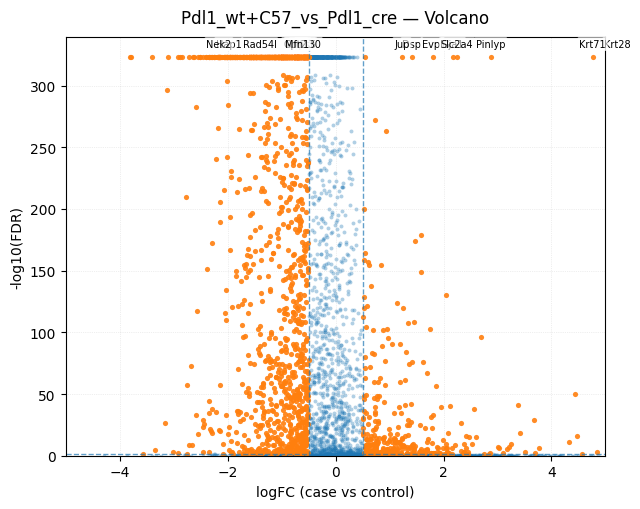

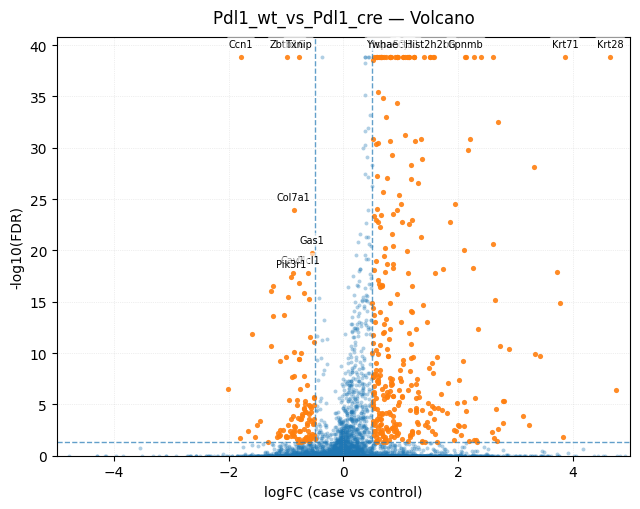

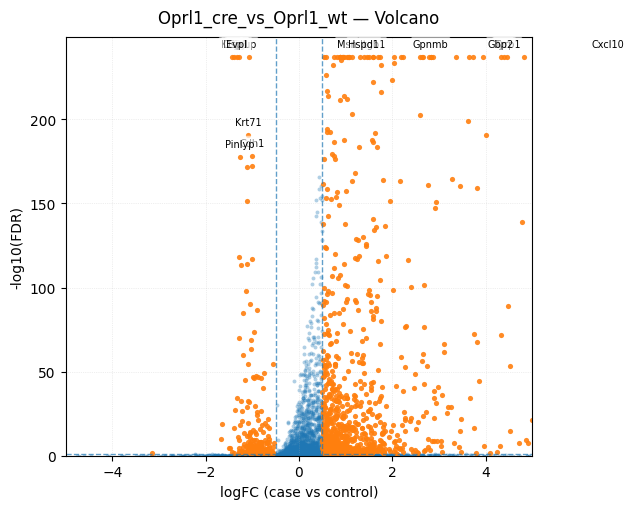

In [56]:
for name, df in results_scanpy.items():
    nice_volcano(
        df,
        title=f"{name} — Volcano",
        fdr_thr=0.05,
        lfc_thr=0.5,
        xlim=(-5, 5),   # <-- cut the x-axis here
        top_n_each=8
    )